In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf

import gpflow
from gpflow.utilities import print_summary, positive
from gpflow.ci_utils import ci_niter
from gpflow.base import Parameter
from gpflow.utilities.ops import difference_matrix
from gpflow.kernels.base import Kernel
from gpflow.kernels.stationaries import IsotropicStationary, Stationary

from typing import List, Optional, Union

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import  GridSpec
import matplotlib.dates as dates
from matplotlib.dates import date2num, num2date
from datetime import datetime
dates.set_epoch("1969-01-01T00:00")

import ipywidgets as widgets
from IPython.display import display

%matplotlib nbagg

In [2]:
pd.read_csv("birthdates-1968-1988.csv")

,year,month,day,births,day_of_year,day_of_week
0,1969,1,1,8486,1,3
1,1969,1,2,9002,2,4
2,1969,1,3,9542,3,5
3,1969,1,4,8960,4,6
4,1969,1,5,8390,5,7
...,...,...,...,...,...,...
7300,1988,12,27,11528,362,2
7301,1988,12,28,11847,363,3
7302,1988,12,29,11704,364,4
7303,1988,12,30,11837,365,5


In [3]:
data = pd.read_csv("birthdates-1968-1988.csv")

day_of_week = np.array(data.day_of_week, dtype="float64").reshape(7305, 1)
day_of_year = np.array(data.day_of_year, dtype="float64").reshape(7305, 1)
k = 7
l = 1
for i in range(7500):
    day_of_week = np.append(day_of_week, k)
    day_of_year = np.append(day_of_year, l)
    k += 1
    l += 1
    if k == 8:
        k = 1
    if l == 366:
        l = 1
    
weekends = 1 * np.add(day_of_week == 6, day_of_week == 7) 

weekdays = np.add(day_of_week == 1, day_of_week == 2) 
weekdays = np.add(weekdays, day_of_week == 3)
weekdays = np.add(weekdays, day_of_week == 4)
weekdays = 1 * np.add(weekdays, day_of_week == 5)


Xlist = [i for i in range(1, 7306, 1)]
X = np.array(Xlist, dtype="float64").reshape(7305, 1)

Y = data["births"]
ybar = np.mean(Y)
s = np.std(Y)

Y = np.array((Y - ybar) / s).reshape(7305, 1)

data = (X, Y)
N = len(X)

M = 100
idx = [int(i) for i in list(np.linspace(0, N, M, endpoint=False))]
Z = X[idx, :].copy()

minibatch_size = 256
train_dataset = tf.data.Dataset.from_tensor_slices((X, Y)).repeat().shuffle(N)

In [4]:
days = np.add(day_of_year == 1, day_of_year == 60)
days = np.add(days, day_of_year == 186)
days = np.add(days, day_of_year == 153)
days = np.add(days, day_of_year == 260)
days = np.add(days, day_of_year == 327)
days = np.add(days, day_of_year == 332)
days = 1 * np.add(days, day_of_year == 360)

In [5]:
class WDaysPeriodic(Kernel):
    
    def __init__(self, base_kernel: IsotropicStationary, period: Union[float, List[float]] = 1.0):
        if not isinstance(base_kernel, IsotropicStationary):
            raise TypeError("Periodic requires an IsotropicStationary kernel...")
    
        super().__init__()
        self.base_kernel = base_kernel
        self.period = Parameter(period, transform=positive())
        self.base_kernel._validate_ard_active_dims(self.period)
    
    @property
    def active_dims(self):
        return self.base_kernel.active_dims
    
    @active_dims.setter
    def active_dims(self, value):
        self.base_kernel.active_dims = value
        
    def K_diag(self, X: tf.Tensor) -> tf.Tensor:
        return self.base_kernel.K_diag(X)

    def K(self, X: tf.Tensor, X2: Optional[tf.Tensor] = None) -> tf.Tensor:
        r = np.pi * (difference_matrix(X, X2)) / self.period
        scaled_sine = tf.sin(r) / self.base_kernel.lengthscales
        sine_r2 = tf.reduce_sum(tf.square(scaled_sine), -1)
        Ix = tf.gather_nd(tf.constant(weekdays), tf.cast(X, tf.int32))
        Ix = tf.cast(tf.reshape(Ix, [len(X), 1]), tf.float64)
        if X2 is None:
            Ix2 = Ix 
        else:
            Ix2 = tf.gather_nd(tf.constant(weekdays), tf.cast(X2, tf.int32))
            Ix2 = tf.cast(tf.reshape(Ix2, [len(X2), 1]), tf.float64)
        K = tf.linalg.matmul(Ix, Ix2, transpose_b=True) * self.base_kernel.K_r2(sine_r2)
        return K   

class WEndsPeriodic(Kernel):
    
    def __init__(self, base_kernel: IsotropicStationary, period: Union[float, List[float]] = 1.0):
        if not isinstance(base_kernel, IsotropicStationary):
            raise TypeError("Periodic requires an IsotropicStationary kernel...")
    
        super().__init__()
        self.base_kernel = base_kernel
        self.period = Parameter(period, transform=positive())
        self.base_kernel._validate_ard_active_dims(self.period)
        
    @property
    def active_dims(self):
        return self.base_kernel.active_dims
    
    @active_dims.setter
    def active_dims(self, value):
        self.base_kernel.active_dims = value
        
    def K_diag(self, X: tf.Tensor) -> tf.Tensor:
        return self.base_kernel.K_diag(X)
    
    def K(self, X: tf.Tensor, X2: Optional[tf.Tensor] = None) -> tf.Tensor:
        Ix = tf.gather_nd(tf.constant(weekends), tf.cast(X, tf.int32))
        Ix = tf.cast(tf.reshape(Ix, [len(X), 1]), tf.float64)
        if X2 is None:
            Ix2 = Ix 
        else:
            Ix2 = tf.gather_nd(tf.constant(weekends), tf.cast(X2, tf.int32))
            Ix2 = tf.cast(tf.reshape(Ix2, [len(X2), 1]), tf.float64)

        r = np.pi * (difference_matrix(X, X2)) / self.period
        scaled_sine = tf.sin(r) / self.base_kernel.lengthscales
        sine_r2 = tf.reduce_sum(tf.square(scaled_sine), -1)
        K = tf.linalg.matmul(Ix, Ix2, transpose_b=True) * self.base_kernel.K_r2(sine_r2)
        return K

class DayOfYearPeriodic(Kernel):
    
    def __init__(self, base_kernel: IsotropicStationary, period: Union[float, List[float]] = 1.0):
        if not isinstance(base_kernel, IsotropicStationary):
            raise TypeError("Periodic requires an IsotropicStationary kernel...")
    
        super().__init__()
        self.base_kernel = base_kernel
        self.period = Parameter(period, transform=positive())
        self.base_kernel._validate_ard_active_dims(self.period)
        
    @property
    def active_dims(self):
        return self.base_kernel.active_dims
    
    @active_dims.setter
    def active_dims(self, value):
        self.base_kernel.active_dims = value
        
    def K_diag(self, X: tf.Tensor) -> tf.Tensor:
        return self.base_kernel.K_diag(X)
    
    def K(self, X: tf.Tensor, X2: Optional[tf.Tensor] = None) -> tf.Tensor:
        Ix = tf.gather_nd(tf.constant(days), tf.cast(X, tf.int32))
        Ix = tf.cast(tf.reshape(Ix, [len(X), 1]), tf.float64)
        if X2 is None:
            Ix2 = Ix 
        else:
            Ix2 = tf.gather_nd(tf.constant(days), tf.cast(X2, tf.int32))
            Ix2 = tf.cast(tf.reshape(Ix2, [len(X2), 1]), tf.float64)

        r = np.pi * (difference_matrix(X, X2)) / self.period
        scaled_sine = tf.sin(r) / self.base_kernel.lengthscales
        sine_r2 = tf.reduce_sum(tf.square(scaled_sine), -1)
        K = tf.linalg.matmul(Ix, Ix2, transpose_b=True) * self.base_kernel.K_r2(sine_r2)
        return K

## Modelo

In [6]:
k1 = gpflow.kernels.SquaredExponential(0.2, 260)  # long trend
k2 = gpflow.kernels.SquaredExponential(0.01, 30)  # short trend
k3 = gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential(2, 0.8), 7) * gpflow.kernels.SquaredExponential(0.5, 2000) #
k4 = gpflow.kernels.Periodic(gpflow.kernels.SquaredExponential(0.2, 0.2), 365.25) * gpflow.kernels.SquaredExponential(1, 1000)
k5 = WDaysPeriodic(gpflow.kernels.SquaredExponential(1, 2000), 365.25)  # weekday
k6 = WEndsPeriodic(gpflow.kernels.SquaredExponential(1, 2000), 365.25)
k7 = DayOfYearPeriodic(gpflow.kernels.SquaredExponential(1, 5000), 365.25)
k8 = gpflow.kernels.SquaredExponential(1, 1200) # 0.005
k9 = gpflow.kernels.White(0.01)

kernel = k1 + k2 + k3 + k4 + k5 + k6 + k7 + k8 + k9
m = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, whiten=True, num_data=N)

gpflow.set_trainable(m.kernel.kernels[2].kernels[0].period, False)
gpflow.set_trainable(m.kernel.kernels[3].kernels[0].period, False)
gpflow.set_trainable(m.kernel.kernels[4].period, False)
gpflow.set_trainable(m.kernel.kernels[5].period, False)
gpflow.set_trainable(m.kernel.kernels[6].period, False)
gpflow.set_trainable(m.inducing_variable, True)

<IPython.core.display.Javascript object>


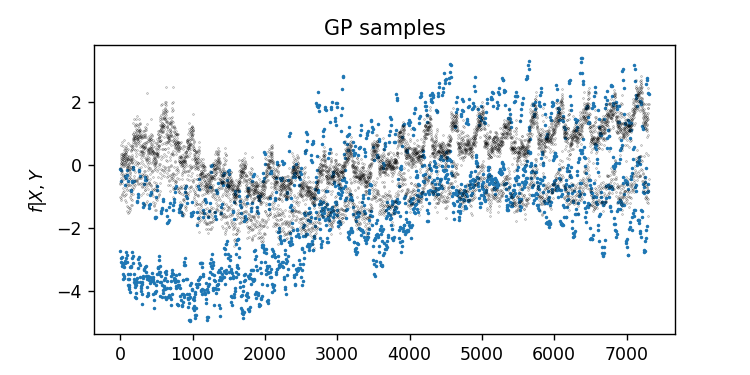

In [7]:
# Genera muestras a priori para testear el kernel

Xt = np.round_(np.linspace(0, 7305, 2000)).astype(np.float64)[:, None]
num_samples = ci_niter(1)
f = m.predict_f_samples(Xt, num_samples)

plt.figure(figsize=(6,3))
for i in range(0, num_samples):
    plt.plot(Xt, f[i, :, :], ".", alpha=1, markersize=2)

plt.plot(X, Y, "k.", alpha=0.5, markersize=0.5)
plt.xlabel("$x$")
plt.ylabel("$f|X,Y$")
plt.title("GP samples")

plt.show()

In [8]:
def run_adam(model, iterations):
    logf = []
    train_iter = iter(train_dataset.batch(minibatch_size))
    training_loss = model.training_loss_closure(train_iter, compile=True)  
    optimizer = tf.optimizers.Adam()
    
    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)
        
    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            print(step, elbo)
            logf.append(elbo)
    print(step, -training_loss().numpy())
    return logf

In [9]:
maxiter = ci_niter(60000)
logf = run_adam(m, maxiter)

0 -29607.794427818088
10 -27170.928277269802
20 -24644.82248331377
30 -23590.51454955807
40 -22508.617442350922
50 -21366.995727556416
60 -21477.86644377715
70 -19917.25296475393
80 -20343.614042811776
90 -19658.924175855318
100 -19480.49984160006
110 -19704.17876106815
120 -18790.89925007917
130 -18441.61390027789
140 -18161.571620679715
150 -17534.606182838204
160 -18102.122320557202
170 -17630.020000216107
180 -17496.90546699151
190 -17435.79236451073
200 -16829.966072787985
210 -17322.80872515906
220 -16467.95853350981
230 -16305.082625707528
240 -16674.126969474015
250 -16252.127405813759
260 -16671.34607971102
270 -15842.926655528994
280 -15806.857874002779
290 -16070.237214772886
300 -15539.025160986106
310 -15463.953450859406
320 -15865.258226165866
330 -15535.491080027978
340 -15517.444793398696
350 -15199.920460316174
360 -14982.879339941113
370 -15227.368363898262
380 -14563.142085773738
390 -14933.903069987095
400 -14881.2839007623
410 -14302.578422487615
420 -14570.0065301

3440 -7318.406169931179
3450 -7421.668863722034
3460 -6861.693769746332
3470 -6743.240802322114
3480 -7239.228467974132
3490 -6820.432137401709
3500 -7027.734806273607
3510 -6806.193729070614
3520 -6930.3410668822735
3530 -6696.937604698466
3540 -7239.1468425282155
3550 -6848.624045531273
3560 -6987.229081097231
3570 -6511.923030161923
3580 -7075.6793047588435
3590 -6699.80828219255
3600 -6502.041846130436
3610 -6620.074264821546
3620 -6783.107213941829
3630 -6536.054005178253
3640 -6748.145007467901
3650 -6645.719925475368
3660 -6592.049194284302
3670 -6662.292288389332
3680 -6725.947242278273
3690 -6565.2587690112705
3700 -6559.390976925712
3710 -6154.767464310427
3720 -6230.085965163577
3730 -6288.044382767451
3740 -6915.7458647617095
3750 -6253.29890508758
3760 -6425.1487619943955
3770 -6437.594993826099
3780 -6357.387826970774
3790 -6234.935185483467
3800 -6292.242578460645
3810 -6476.196224195928
3820 -6444.58423064023
3830 -6261.554383671279
3840 -6171.5165080924835
3850 -6036.7

6830 -2578.387767257112
6840 -3612.846556855928
6850 -3160.7974362330633
6860 -2172.39112237525
6870 -2303.33504574066
6880 -1999.1381671981221
6890 -1822.9716234794048
6900 -2800.019119278825
6910 -2015.3323918076217
6920 -3506.9063620299517
6930 -1967.5623538177217
6940 -2791.447208552354
6950 -3541.620644816499
6960 -4022.8361442245136
6970 -2290.261030920011
6980 -3462.9808193480594
6990 -2934.8551612536503
7000 -2348.929127618782
7010 -2698.4054735680784
7020 -1981.926194008685
7030 -3380.441316660686
7040 -2028.8410184038728
7050 -3574.8007614565963
7060 -1522.2216694282097
7070 -3500.5959408554622
7080 -1764.3048291693124
7090 -3503.167840918222
7100 -2606.414981424971
7110 -1607.0510007500234
7120 -1892.6868321460768
7130 -3570.1796150693644
7140 -2653.4128422727745
7150 -2222.984747074799
7160 -3339.0383959054707
7170 -2484.3155889112027
7180 -3368.1655573799476
7190 -2687.107691122129
7200 -2163.9341185851667
7210 -1800.9354475351522
7220 -2594.7573340649533
7230 -1681.490963

10160 -2133.34531820266
10170 -2197.6538873045706
10180 -2562.564677550864
10190 -1937.2838872745242
10200 -2702.0726133995054
10210 -881.6941950029141
10220 -2567.373854264634
10230 -1421.2353846781732
10240 -1283.602789383848
10250 -3299.245354014708
10260 -1374.5183431924395
10270 -1517.8134522222877
10280 -5615.812701065184
10290 -2691.7320713251574
10300 -3082.1980172786316
10310 -3639.5669325880367
10320 -3067.116235318792
10330 -1434.7181422049987
10340 -1481.5730075337442
10350 -894.2583409169939
10360 -1435.8818136642167
10370 -2056.8160201665064
10380 -2232.958446116756
10390 -1295.7887402471908
10400 -1852.824763475194
10410 -1753.766856218625
10420 -1031.1759175653165
10430 -1778.4629389852971
10440 -2567.596658735441
10450 -1809.6528919596194
10460 -1980.9012536293212
10470 -2250.141128968656
10480 -3731.133451612304
10490 -1865.069460188427
10500 -1737.2396784306097
10510 -2815.7147791545967
10520 -2057.0234435543393
10530 -1824.4209765143437
10540 -2368.32350344537
10550

13380 -3497.697338595809
13390 -2199.3128101727507
13400 -2471.3214867045754
13410 -2383.260477910685
13420 -4462.060332226643
13430 -2019.2715489201767
13440 -694.6745722523262
13450 -1534.8747684093746
13460 -1481.1041359915941
13470 -1762.1288919420124
13480 -1882.196719054256
13490 -2548.9258084799417
13500 -1925.9809433931198
13510 -974.6187706932551
13520 -1508.9568412422786
13530 -2223.8799073187083
13540 -2119.8825361623476
13550 -1560.3933907979742
13560 -2253.492002438304
13570 -2246.4779128769496
13580 -3069.6208102060555
13590 -3250.8050333550473
13600 -2274.96673478059
13610 -1388.1231452292025
13620 -2988.416886479911
13630 -1134.7674019384713
13640 -1539.2238867346273
13650 -1979.5475109164584
13660 -3560.1329642676383
13670 -2729.768842687759
13680 -3413.380151746768
13690 -2541.1075769574913
13700 -980.2797050353427
13710 -2114.8029086371166
13720 -1794.1021812179881
13730 -1451.9734724413754
13740 -1185.3412911471241
13750 -3071.248801046995
13760 -1843.166433299771
1

16590 -1085.7392722529298
16600 -1853.5955458355493
16610 -1650.2324289519852
16620 -711.6059684950395
16630 -3401.0082331363574
16640 -2809.1959596463
16650 -2412.2764481989207
16660 -2811.58742501749
16670 -1552.5596219983388
16680 -1918.044413866052
16690 -2534.4324432761496
16700 -1919.106964861438
16710 -1986.8845220028356
16720 -818.792402796748
16730 -1798.6548923330758
16740 -2014.3972457710968
16750 -1516.9420787627564
16760 -1611.7348778842231
16770 -856.8082684322465
16780 -1987.820501878414
16790 -1660.361646084869
16800 -2209.135308218204
16810 -2363.6299886311735
16820 -1373.926950012295
16830 -1971.7559954791097
16840 -2101.8836649648274
16850 -1585.4988114084313
16860 -2452.415063841343
16870 -3007.627153805495
16880 -2314.413754318447
16890 -1032.6723800772304
16900 -1265.4650268414946
16910 -1336.247346101685
16920 -1301.4629124458215
16930 -2675.2239115794014
16940 -1071.1278804581636
16950 -1640.9368701263434
16960 -2146.70360724734
16970 -3093.1761047837676
16980 -

19820 -2660.12014285048
19830 -2021.1016142094595
19840 -1563.3085195009855
19850 -1037.6564468447807
19860 -620.3462120940176
19870 -1022.0204123171877
19880 -3201.8045918182966
19890 -2190.8802235253734
19900 -1326.8911639365692
19910 -2581.3588189367993
19920 -1493.4741952123372
19930 -2662.119171970229
19940 -1750.5272056119309
19950 -2730.2272121762217
19960 -2794.101803243528
19970 -1221.6580463411412
19980 -1053.103963100653
19990 -1707.273021062001
20000 -2089.4785375389674
20010 -1347.1839399689168
20020 -1272.758085600424
20030 -1930.1415830507683
20040 -1145.4829292721383
20050 -2775.715084046211
20060 -2405.5647869470945
20070 -3427.870728944364
20080 -1870.3153457824073
20090 -2258.727627109048
20100 -1025.9622246252366
20110 -1276.7413016365358
20120 -3329.875414704819
20130 -3010.409305175346
20140 -1541.640293120386
20150 -3890.7505682379983
20160 -4115.391107938152
20170 -353.3152340023504
20180 -1307.6789486749103
20190 -1663.8963134670412
20200 -2095.511421837687
202

23050 -1510.3547209316957
23060 -1801.7530422791071
23070 -1160.175425534761
23080 -1084.1003146999462
23090 -1202.039599972923
23100 -2887.3463869349434
23110 -894.6074753482764
23120 -2453.59370966383
23130 -2678.1501601457644
23140 -2410.013151500777
23150 -2635.4828272329364
23160 -2119.297423280752
23170 -1173.2114403186947
23180 -2338.933892671843
23190 -3827.0802068465027
23200 -1732.5264983856423
23210 -2182.9563968397956
23220 -2515.0271257684008
23230 -1150.237519838411
23240 -871.8295276533695
23250 -1983.9630885848821
23260 -2098.2161680785684
23270 -766.9807841767847
23280 -1453.999480801829
23290 -2359.531196291366
23300 -3350.3528467951314
23310 -2406.9891282430403
23320 -1692.5672492682388
23330 -2936.531121072329
23340 -979.6007455446625
23350 -1283.1727027174406
23360 -1895.4230305720484
23370 -1993.1249487208254
23380 -2833.436287501526
23390 -1978.9015899821316
23400 -2235.0523898859733
23410 -352.19089759055976
23420 -1663.0504790805169
23430 -855.2150323600038
234

26260 -3533.1990743723563
26270 -1909.596893818959
26280 -1534.4744050324568
26290 -1191.534628496438
26300 -1779.3218269641393
26310 -1763.645278369
26320 -1388.473945696535
26330 -1933.4268972198604
26340 -2096.2576169096856
26350 -537.4290921654338
26360 -2137.343195989688
26370 -1659.5653400515187
26380 -2844.4035118657466
26390 -1454.8906431978335
26400 -720.6263907798773
26410 -2336.608773759029
26420 -2873.029302876464
26430 -2628.5416179707536
26440 -2427.6025787808876
26450 -1693.7091952150324
26460 -2067.1019404564454
26470 -1056.4450225698715
26480 -1255.2174931824388
26490 -2629.6031808491653
26500 -783.5509675338668
26510 -1160.2125611292456
26520 -766.929164564898
26530 -2494.0862769100454
26540 -1156.424642032663
26550 -1902.6127369129986
26560 -2646.7723356926786
26570 -1786.752951268506
26580 -1252.9694764708802
26590 -1861.8214130233923
26600 -1946.9872079197448
26610 -2592.407690658101
26620 -1460.980849298124
26630 -1084.395782631008
26640 -2614.976480731567
26650 -

29490 -4862.315741665782
29500 -2699.909824027933
29510 -1158.1319993266375
29520 -4119.0916021039975
29530 -1727.1250438519007
29540 -1337.7716131854938
29550 -1686.5095314458028
29560 -3004.8534629128694
29570 -1403.558871712739
29580 -1714.865961724424
29590 -1793.7628501706963
29600 -2519.8721322487536
29610 -3659.2492652521087
29620 -1379.1019149600002
29630 -3076.243515970218
29640 -2010.416783444259
29650 -972.550273417658
29660 -618.5903209850894
29670 -1546.7336099256058
29680 -2966.1918212362484
29690 -2034.1363533698109
29700 -3345.861064874824
29710 -2110.173810372443
29720 -1422.584336599553
29730 -4093.2498753925147
29740 -1626.5267071366536
29750 -1640.5874605385077
29760 -2382.93350918806
29770 -1767.7141800081797
29780 -2185.283338262059
29790 -2772.531896426681
29800 -1586.8212248477942
29810 -2455.3469205276024
29820 -1800.9663288729803
29830 -898.5543422670844
29840 -780.5787666451196
29850 -1032.4176543330625
29860 -1935.043679401875
29870 -1200.2453983479886
29880

32700 -2577.2061246471676
32710 -2911.3731510198236
32720 -1568.2986878784166
32730 -1234.584273331499
32740 -2537.3197717119824
32750 -2408.4558244881528
32760 -1685.7325094453508
32770 -1226.4810146875259
32780 -409.73354494804164
32790 -2803.711337826075
32800 -847.7973229278145
32810 -1803.9104662038842
32820 -1064.9182860980898
32830 -1628.1764835303943
32840 -4012.0283192043294
32850 -2243.7192426878305
32860 -1817.6036712844566
32870 -2166.219402154575
32880 -1927.4601264443143
32890 -2451.111418356286
32900 -1928.0675188798318
32910 -989.8224083628213
32920 -2188.563236508673
32930 -1297.0156176968112
32940 -970.5410415779878
32950 -830.3107043532256
32960 -1106.0786415368545
32970 -1300.2376131933652
32980 -932.6608953223616
32990 -1905.2942008653217
33000 -2322.8499175824286
33010 -2262.033549762264
33020 -1574.9263580821407
33030 -2735.1153522015106
33040 -1951.847697145146
33050 -1422.5981058668215
33060 -1560.8309274284475
33070 -2013.3785318881114
33080 -1735.927672518288

35930 -3242.143884302119
35940 -2577.376018506309
35950 -3504.738572577863
35960 -1413.9662097227567
35970 -1421.1065657450947
35980 -3019.774908887812
35990 -1481.3740510770958
36000 -1228.468341784168
36010 -1443.9056851926132
36020 -2279.483106723867
36030 -2526.8030326309026
36040 -1017.0637656361332
36050 -1203.5565438040592
36060 -1502.3104805756582
36070 -2505.2334935947783
36080 -2922.135975773307
36090 -1429.862462118008
36100 -1231.3263916172618
36110 -520.5442070107447
36120 -720.5031502447625
36130 -1624.1948971472198
36140 -1225.4615210983677
36150 -2988.4820674785437
36160 -2398.522059220388
36170 -1724.5206924957822
36180 -2135.2028596076643
36190 -3205.04465447724
36200 -1390.3259626729023
36210 -2512.8467157517703
36220 -2551.568340607167
36230 -2225.5839488962138
36240 -3002.4898555325926
36250 -936.1370662486904
36260 -2212.887800507754
36270 -3268.97208870095
36280 -1414.4678783708932
36290 -1799.868040980248
36300 -2258.4756401162495
36310 -1061.8989080931883
36320

39140 -698.7109917135386
39150 -1254.532176092749
39160 -1196.3285760142865
39170 -2054.6533135902046
39180 -2595.9868723459804
39190 -2819.5050069108697
39200 -2809.0325880783644
39210 -542.2229701381448
39220 -420.83754476816193
39230 -802.994173840367
39240 -2805.056806687458
39250 -1734.7322879129515
39260 -3593.4401710563398
39270 -2711.323984223046
39280 -1184.693586140963
39290 -3117.7820156567514
39300 -1342.7822708555216
39310 -2415.4720405276666
39320 -2004.0194116437292
39330 -721.1395994681261
39340 -3240.362526213727
39350 -2113.9957501590566
39360 -1917.0430886323527
39370 -2304.3898634925877
39380 -1808.908655790596
39390 -2864.975075658294
39400 -2477.949537087951
39410 -3334.5924266182597
39420 -1309.6695291133203
39430 -1633.6155124701445
39440 -2243.714882234048
39450 -2656.8127213540592
39460 -2122.82970732332
39470 -2083.6958900613654
39480 -4157.332927922593
39490 -1525.2974002104427
39500 -2623.7843370889777
39510 -1407.9727290215856
39520 -1847.1198942624487
395

42370 -2694.631726219239
42380 -1956.5452612017457
42390 -1983.3966957072157
42400 -2948.426072244474
42410 -1501.3095626599097
42420 -1312.8562411633093
42430 -764.6704751544573
42440 -1708.236275039253
42450 -800.5703465658382
42460 -1237.6830364664831
42470 -2541.863956219435
42480 -1916.1432724778522
42490 -374.581883552078
42500 -1846.4535209286605
42510 -1617.7693709001505
42520 -1398.282724097462
42530 -796.434936769681
42540 -1524.000832432461
42550 -597.0076850211681
42560 -2524.990243573153
42570 -998.0558992424956
42580 -2501.324024786203
42590 -2435.9194674506425
42600 -1380.3711445131723
42610 -1880.946239127637
42620 -1152.1454234165603
42630 -1127.1679453041374
42640 -1537.2359789407014
42650 -3601.584467308266
42660 -1667.4229270856504
42670 -4078.0424211716245
42680 -311.1043729163266
42690 -1778.8775597953418
42700 -3886.4263235334397
42710 -2974.5664868164645
42720 -1703.1500845620928
42730 -4222.994362207213
42740 -3068.133476632483
42750 -3361.900626656423
42760 -1

45610 -1578.5568107352137
45620 -1667.1579368760931
45630 -1558.203863541328
45640 -1232.6124718428605
45650 -578.9192271366095
45660 -4135.932235814116
45670 -1767.2035972915633
45680 -1222.778290012715
45690 -1592.2009236337249
45700 -2200.46305241535
45710 -2129.4106929377804
45720 -1952.533176389265
45730 -2172.1795004374753
45740 -1829.798662744739
45750 -3034.1146020032747
45760 -1835.3550352788002
45770 -3110.1802872744997
45780 -1497.5616578627496
45790 -1983.4547601151392
45800 -2445.0957735235925
45810 -2456.864577227919
45820 -1343.8053582822301
45830 -1614.958887620694
45840 -2155.1332427683587
45850 -1620.8682503365599
45860 -1155.0387316093336
45870 -3166.9264988099258
45880 -1492.2310154164556
45890 -453.7925112386599
45900 -2082.4354940652747
45910 -970.783996909799
45920 -5209.112508800241
45930 -1957.8826445061611
45940 -2560.268016652944
45950 -1971.2690716006161
45960 -1667.3951409988788
45970 -3595.6813109330833
45980 -1654.9232230929729
45990 -2878.4093191334605
4

48840 -1804.7346397203123
48850 -1152.615056202709
48860 -1256.2301905868828
48870 -2097.6787669689506
48880 -1859.7640391887883
48890 -4446.6465249547355
48900 -2556.904225369647
48910 -560.5061452872753
48920 -185.37066759811742
48930 -1692.634663390912
48940 -2221.773100067811
48950 -2583.6888624990115
48960 -2095.6865423048116
48970 -643.3604823052813
48980 -1752.8618251739417
48990 -2271.7564991600507
49000 -3446.6990397067643
49010 -1599.9574257520715
49020 -1103.8474965891405
49030 -1516.6486405373284
49040 -3200.9869905993337
49050 -2513.872608131614
49060 -1152.480803809651
49070 -2206.178405682316
49080 -1817.4827952115388
49090 -1264.8061473577468
49100 -2680.429240373767
49110 -2118.10041359266
49120 -1298.0376409895948
49130 -1780.6977078068649
49140 -1933.3207765165291
49150 -2006.0964017868166
49160 -3217.160912024421
49170 -1886.9849261337013
49180 -3057.502636655961
49190 -1404.5563175505572
49200 -1346.0762955380958
49210 -2077.216835504583
49220 -3388.8507667765734
4

52080 -1887.8106387053454
52090 -2871.8386202371485
52100 -1543.1140181866144
52110 -166.04688448600538
52120 -2427.604914328884
52130 -784.6436852061973
52140 -3265.619545918941
52150 -1239.5145212644793
52160 -3573.3710711995327
52170 -699.8595996252884
52180 -3119.3221848004864
52190 -921.2590401088822
52200 -742.6970799917041
52210 -2767.587521344915
52220 -1810.0195594095296
52230 -2716.078511358793
52240 -5155.854417185137
52250 -1397.5381238600385
52260 -3134.363970253355
52270 -2975.7657754341385
52280 -2947.2060383040102
52290 -2617.205812892439
52300 -1950.3603614677031
52310 -796.4183761055738
52320 -588.9618625738194
52330 -1884.9371494751078
52340 -2573.8905850763704
52350 -2812.2431698553337
52360 -3341.452746878412
52370 -1657.7235472693326
52380 -2543.0280825900536
52390 -656.2776944652911
52400 -1909.1692378546575
52410 -1987.8978072326533
52420 -1828.144032738718
52430 -2209.6027997201763
52440 -3060.782170852404
52450 -1761.4758169901563
52460 -1006.0123845727485
524

55300 -3110.6123093835095
55310 -1213.9699789998963
55320 -2568.9672998908754
55330 -1707.2157476640957
55340 -2993.713008339206
55350 -2294.9116154613635
55360 -3030.658381318735
55370 -2449.7932198964904
55380 -2202.94368153822
55390 -1797.5821831075366
55400 -2369.019683341541
55410 -2657.537022972312
55420 -2725.7346667899747
55430 -1673.0066297550882
55440 -1138.8516907503495
55450 -1156.7993455182511
55460 -1815.1161585701734
55470 -3275.337350637061
55480 -2187.551698556335
55490 -2347.5470294995707
55500 -1876.3326285314492
55510 -459.2759992731583
55520 -2568.3727956209573
55530 -1649.6184720193378
55540 -2207.8495070982144
55550 -3276.7022284645936
55560 -1215.5869255627933
55570 -2584.417018554911
55580 -1138.9370214850408
55590 -1186.1222709046565
55600 -1911.24342575196
55610 -1889.235073620262
55620 -2545.725269660744
55630 -2908.699544221757
55640 -2293.9038927322263
55650 -2750.7612296155908
55660 -1582.5046727560134
55670 -1123.4779773027476
55680 -1272.9095462872092
5

58520 -513.3155334318026
58530 -3064.1540270109213
58540 -2994.077916070026
58550 -2963.4230579390287
58560 -2863.762621025855
58570 -2891.397860885259
58580 -3139.198009931588
58590 -1128.9119065987752
58600 -3354.4382502348362
58610 -2193.984857730378
58620 -2318.5101648018117
58630 -2182.869489783058
58640 -1486.196789496241
58650 -1393.718938833886
58660 -2321.817400478554
58670 -698.6078713904316
58680 -2501.0914359430058
58690 -1639.2492746737141
58700 -1618.1916090319323
58710 -2625.9470398442977
58720 -1892.1597804368291
58730 -1942.6605382127455
58740 -1587.649404077885
58750 -2321.7011341078846
58760 -3063.30255707191
58770 -2565.031440376846
58780 -897.0662555119183
58790 -1768.2060235054382
58800 -1850.2977132317212
58810 -2199.389782775617
58820 -2941.0396899941084
58830 -1214.6290698906714
58840 -3464.2100855588487
58850 -1331.0836910002192
58860 -477.5352524022015
58870 -2561.230023930061
58880 -1725.4550199255061
58890 -1470.8802528080616
58900 -1613.844326114533
58910 

<IPython.core.display.Javascript object>


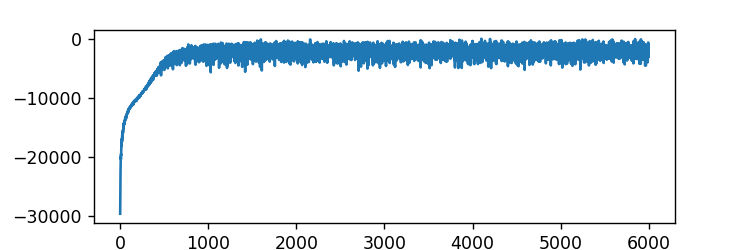

In [10]:
fig, ax = plt.subplots(1, figsize=(6, 2))
ax.plot(logf)
plt.show()

In [11]:
print_summary(m, fmt='notebook')

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.053282529129689685
SVGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,264.66975955317133
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.1353521376291255e-08
SVGP.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,42.3799556804459
SVGP.kernel.kernels[2].kernels[0].base_kernel.variance,Parameter,Softplus,,True,(),float64,1.8692874812611344
SVGP.kernel.kernels[2].kernels[0].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.703450961040902
SVGP.kernel.kernels[2].kernels[0].period,Parameter,Softplus,,False,(),float64,6.999999999999999
SVGP.kernel.kernels[2].kernels[1].variance,Parameter,Softplus,,True,(),float64,0.44162220767418353
SVGP.kernel.kernels[2].kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,2014.1582715851632
SVGP.kernel.kernels[3].kernels[0].base_kernel.variance,Parameter,Softplus,,True,(),float64,0.33777227568894563


In [13]:
data = pd.read_csv("birthdates-1968-1988.csv")
Xd = num2date(data.index.values)

## Figuras

In [15]:
f = m.predict_f_samples(Xt, full_cov=True, num_samples=10)

<IPython.core.display.Javascript object>


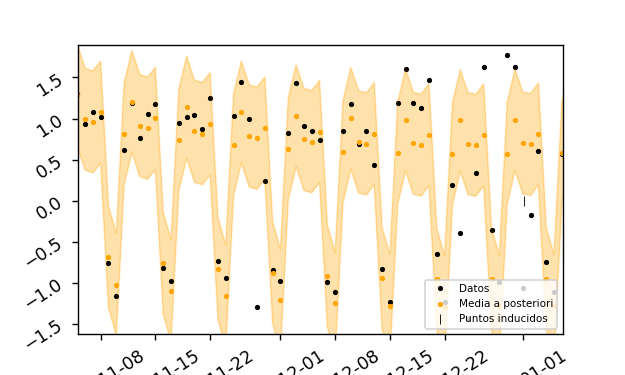

interactive(children=(FloatSlider(value=1.0, description='data alpha:', max=1.0), FloatSlider(value=4.0, descr…

In [14]:
n = 10001
Xt = np.round_(np.linspace(0, 10000, n)).astype(np.float64)[:, None]
mpost, spost = m.predict_y(Xt)
mpostc = mpost[1:n+1]
spostc = spost[1:n+1]

Z = m.inducing_variable.Z.numpy()
num_samples = ci_niter(1)

fig, ax = plt.subplots(1, figsize=(5, 3))
plt.title('Predicciones después de entrenar el modelo', fontsize=8)

def update_plot(da, ds, ms, ma, fa, fw):
    np.random.seed(0)
    ax.cla()
    ax.tick_params(labelrotation=33)
    ax.plot_date(Xd, Y, '.', label='Datos', alpha=da, markersize=ds, color='k')
    (mean,) = ax.plot(Xt[:-1], mpostc, '.', color='orange', markersize=ms, alpha=ma, label='Media a posteriori')
    col = mean.get_color()
    ax.plot(Xt[:-1, 0], (mpostc - 2 * spostc ** 0.5)[:, 0], '-', markersize=1, alpha=0.1, color=col)
    ax.plot(Xt[:-1, 0], (mpostc + 2 * spostc ** 0.5)[:, 0], '-', markersize=1, alpha=0.1, color=col) 
    
    ax.fill_between(Xt[:-1, 0],
                    (mpostc - 2 * spostc ** 0.5)[:, 0],
                    (mpostc + 2 * spostc ** 0.5)[:, 0],
                    color = col,
                    alpha = fa, 
                    lw = fw)
    
    
#     for i in range(0, 30):  #'num_samples'
#         ax.plot(Xt[:-1] , f[i, 1:, :], 'b-', alpha=0.15, lw=1.5)
        
    ax.plot(Z, np.zeros_like(Z), 'k|', mew=0.5, label='Puntos inducidos')
    ax.legend(loc='lower right', fontsize=6)
    



da = widgets.FloatSlider(min=0, max=1, value=1, description='data alpha:')
ds = widgets.FloatSlider(min=0, max=4, value=4, description='data size:')
ms = widgets.FloatSlider(min=0, max=4, value=4, description='mean size:')
ma = widgets.FloatSlider(min=0, max=1, value=1, description='mean alpha:')
fw = widgets.FloatSlider(min=0, max=4, value=0.5, description='fill size:')
fa = widgets.FloatSlider(min=0, max=1, value=0.33, description='fill alpha:')


widgets.interactive(update_plot, 
                    da=da, 
                    ds=ds,
                    ms=ms, 
                    ma=ma, 
                    fa=fa, 
                    fw=fw)

<IPython.core.display.Javascript object>


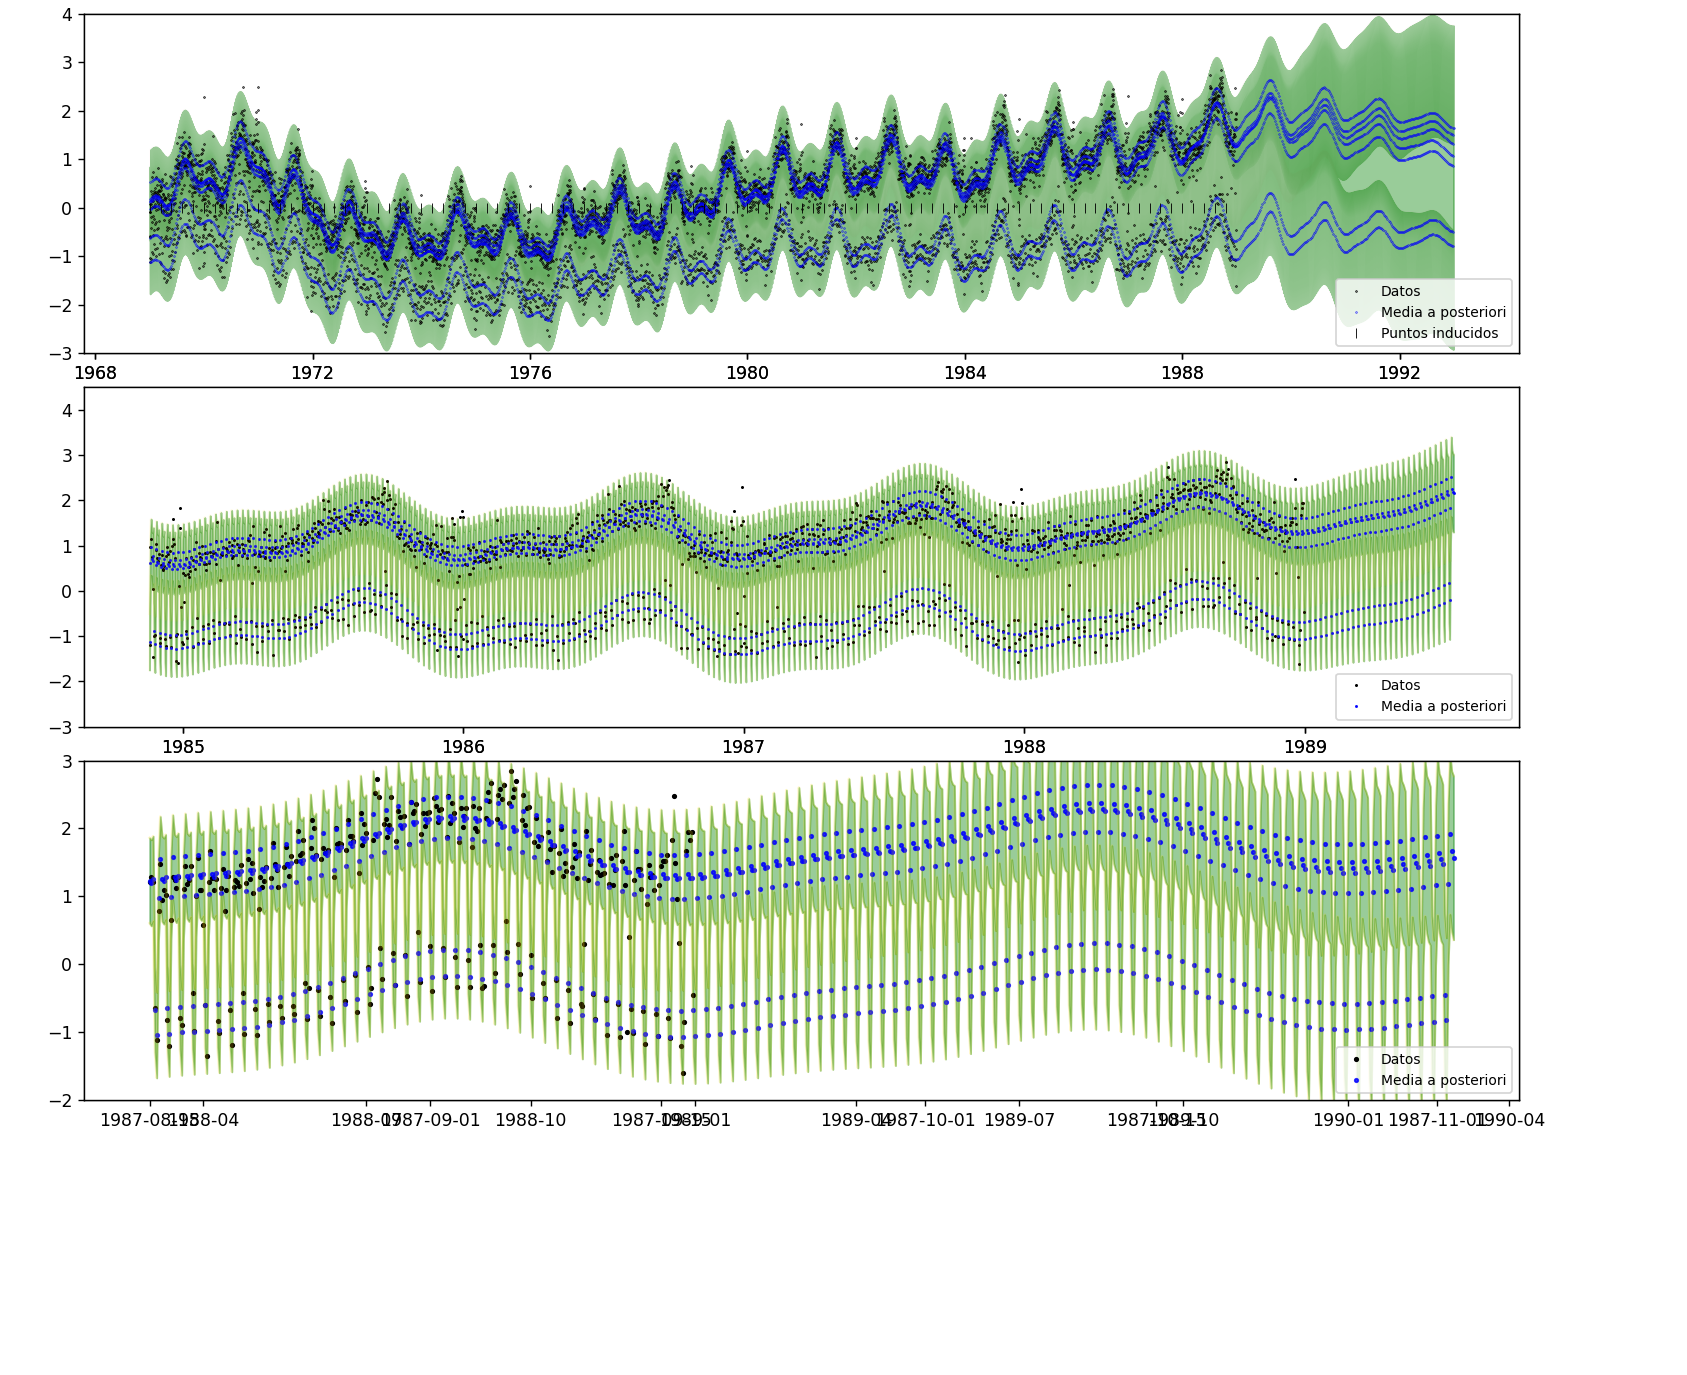

(-2.0, 3.0)

In [32]:
# f = m.predict_f_samples(Xt, num_samples)
n = 8765
Xt = np.round_(np.linspace(0, 8764, n)).astype(np.float64)[:, None]

mpost, spost = m.predict_y(Xt)
mpostc = mpost[1:n+1]
spostc = spost[1:n+1]

Xt = Xt[:-1]

Z = m.inducing_variable.Z.numpy()
num_samples = ci_niter(1)

grid = GridSpec(3, 1, 
                left=0.05, bottom=0.2, 
                right=0.9, top=0.99, wspace=0.05, hspace=0.1)

fig = plt.figure(0, figsize=(13.5, 11))
ax1 = fig.add_subplot(grid[0, 0])
ax2 = fig.add_subplot(grid[1, 0])
ax3 = fig.add_subplot(grid[2, 0])

# ax1.tick_params(labelrotation=1)
ax1.plot_date(Xd, Y, '.', label='Datos', alpha=1, markersize=0.8, color='k')
(mean,) = ax1.plot(Xt, mpostc, '.', color='orangered', markersize=0.7, alpha=0.8, label='Media a posteriori')
col = mean.get_color()
ax1.plot(Xt[:, 0], (mpostc - 2 * spostc ** 0.5)[:, 0], '-', markersize=0.75, alpha=0.01, color='r')
ax1.plot(Xt[:, 0], (mpostc + 2 * spostc ** 0.5)[:, 0], '-', markersize=0.75, alpha=0.01, color='r') 
ax1.fill_between(Xt[:,0],
                (mpostc - 2 * spostc ** 0.5)[:, 0],
                (mpostc + 2 * spostc ** 0.5)[:, 0],
                color = 'orange',
                alpha = 0.4, 
                lw = 1)
# ax1.set_yticks([])
ax1.plot(Z, np.zeros_like(Z), 'k|', mew=0.5, label='Puntos inducidos')
ax1.legend(loc='lower right', fontsize=8)
ax1.set_ylim(-3,4)

k, t = 1700, 5800
# ax2.tick_params(labelrotation=1)
ax2.plot_date(Xd[t:k+t], Y[t:k+t], '.', label='Datos', alpha=1, markersize=1.5, color='k')
(mean,) = ax2.plot(Xt[t:k+t,0], mpostc[t:k+t], '.', color='orangered', markersize=1.5, alpha=0.9, label='Media a posteriori')
col = mean.get_color()
ax2.plot(Xt[t:k+t,0], (mpostc - 2 * spostc ** 0.5)[t:k+t, 0], '-', markersize=0.75, alpha=0.1, color='gold')
ax2.plot(Xt[t:k+t,0], (mpostc + 2 * spostc ** 0.5)[t:k+t, 0], '-', markersize=0.75, alpha=0.1, color='gold')  
ax2.fill_between(Xt[t:k+t,0],
                (mpostc - 2 * spostc ** 0.5)[t:k+t, 0],
                (mpostc + 2 * spostc ** 0.5)[t:k+t, 0],
                color = 'orange',
                alpha = 0.4, 
                lw = 1)
#ax2.set_yticks([])
ax2.legend(loc='lower right', fontsize=8)
ax2.set_ylim(-3,4.5)

k, t = 80,6800
# ax3.tick_params(labelrotation=1)
ax3.plot_date(Xd[t:k+t], Y[t:k+t], '.', label='Datos', alpha=1, markersize=4, color='k')
(mean,) = ax3.plot(Xt[t:k+t,0], mpostc[t:k+t], '.', color='orangered', markersize=4, alpha=0.8, label='Media a posteriori')
col = mean.get_color()
ax3.plot(Xt[t:k+t,0], (mpostc - 2 * spostc ** 0.5)[t:k+t, 0], '-', markersize=1, alpha=0.2, color='gold')
ax3.plot(Xt[t:k+t,0], (mpostc + 2 * spostc ** 0.5)[t:k+t, 0], '-', markersize=1, alpha=0.2, color='gold') 
ax3.fill_between(Xt[t:k+t,0],
                (mpostc - 2 * spostc ** 0.5)[t:k+t, 0],
                (mpostc + 2 * spostc ** 0.5)[t:k+t, 0],
                color = 'orange',
                alpha = 0.4, 
                lw = 1)
#ax3.set_yticks([])
ax3.legend(loc='lower right', fontsize=8)
ax3.set_ylim(-2,3)

#fig.savefig('model.png', dpi=200) 

<IPython.core.display.Javascript object>


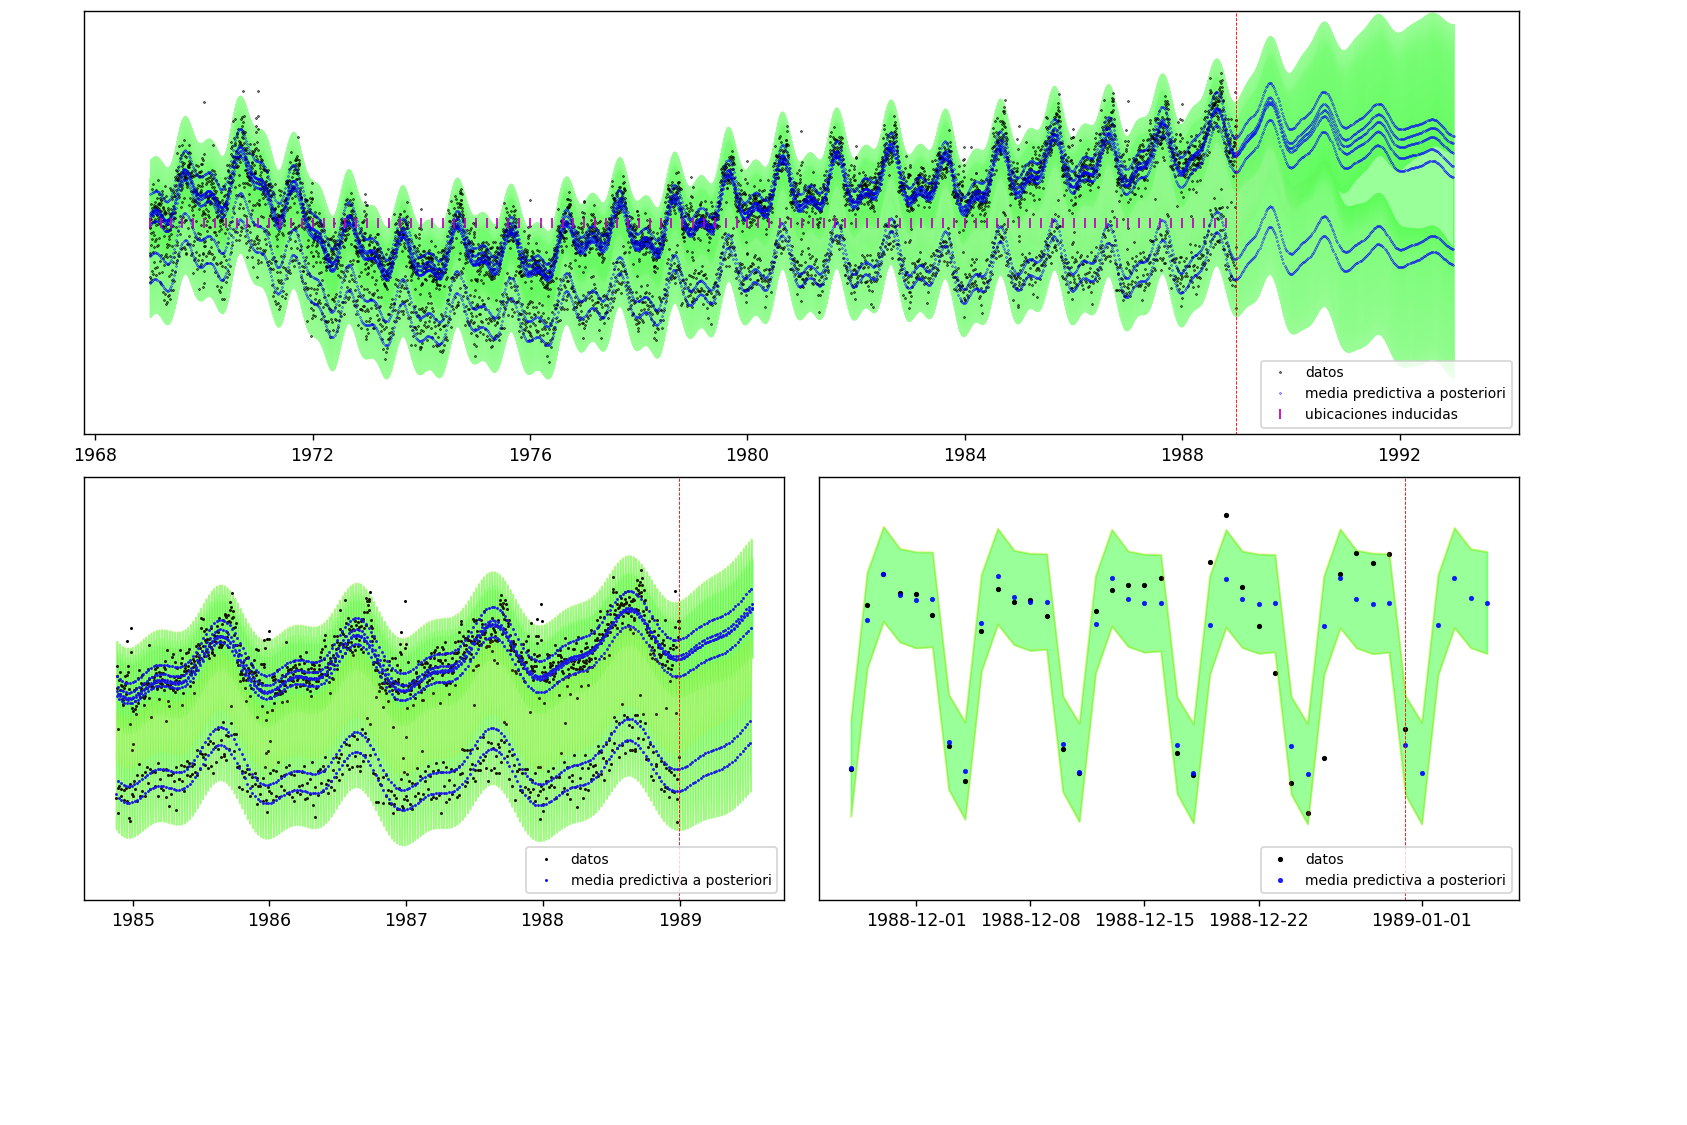

In [75]:
# f = m.predict_f_samples(Xt, num_samples)
n = 8765
Xt = np.round_(np.linspace(0, 8764, n)).astype(np.float64)[:, None]

mpost, spost = m.predict_y(Xt)
mpostc = mpost[1:n+1]
spostc = spost[1:n+1]

Xt = Xt[:-1]

Z = m.inducing_variable.Z.numpy()
num_samples = ci_niter(1)

grid = GridSpec(2, 2, 
                left=0.05, bottom=0.2, 
                right=0.9, top=0.99, wspace=0.05, hspace=0.1)

fig = plt.figure(0, figsize=(13.5, 9))
ax1 = fig.add_subplot(grid[0, :])
ax2 = fig.add_subplot(grid[1, 0])
ax3 = fig.add_subplot(grid[1, 1])

# ax1.tick_params(labelrotation=1)
ax1.plot_date(Xd, Y, '.', label='datos', alpha=1, markersize=0.8, color='k')
(mean,) = ax1.plot(Xt, mpostc, '.', color='blue', markersize=0.7, alpha=0.8, label='media predictiva a posteriori')
col = mean.get_color()
ax1.plot(Xt[:, 0], (mpostc - 2 * spostc ** 0.5)[:, 0], '-', markersize=0.75, alpha=0.01, color='r')
ax1.plot(Xt[:, 0], (mpostc + 2 * spostc ** 0.5)[:, 0], '-', markersize=0.75, alpha=0.01, color='r') 
ax1.fill_between(Xt[:,0],
                (mpostc - 2 * spostc ** 0.5)[:, 0],
                (mpostc + 2 * spostc ** 0.5)[:, 0],
                color = 'lime',
                alpha = 0.4, 
                lw = 1)
ax1.set_yticks([])
ax1.plot(Z, np.zeros_like(Z), 'm|', mew=1, label='ubicaciones inducidas')
ax1.legend(loc='lower right', fontsize=8)
ax1.axvline(x=7304, ymin=-1, ymax=1, ls='--', lw=0.5, color='red')
ax1.set_ylim(-4,4)

k, t = 1700, 5800
# ax2.tick_params(labelrotation=1)
ax2.plot_date(Xd[t:k+t], Y[t:k+t], '.', label='datos', alpha=1, markersize=1.5, color='k')
(mean,) = ax2.plot(Xt[t:k+t,0], mpostc[t:k+t], '.', color='blue', markersize=1.5, alpha=0.9, label='media predictiva a posteriori')
col = mean.get_color()
ax2.plot(Xt[t:k+t,0], (mpostc - 2 * spostc ** 0.5)[t:k+t, 0], '-', markersize=0.75, alpha=0.1, color='gold')
ax2.plot(Xt[t:k+t,0], (mpostc + 2 * spostc ** 0.5)[t:k+t, 0], '-', markersize=0.75, alpha=0.1, color='gold')  
ax2.fill_between(Xt[t:k+t,0],
                (mpostc - 2 * spostc ** 0.5)[t:k+t, 0],
                (mpostc + 2 * spostc ** 0.5)[t:k+t, 0],
                color = 'lime',
                alpha = 0.4, 
                lw = 1)
ax2.set_yticks([])
ax2.legend(loc='lower right', fontsize=8)
ax2.axvline(x=7304, ymin=0, ymax=1, ls='--', lw=0.5, color='red')
ax2.set_ylim(-3,4.5)

k, t = 40,7270
# ax3.tick_params(labelrotation=1)
ax3.plot_date(Xd[t:k+t], Y[t:k+t], '.', label='datos', alpha=1, markersize=4, color='k')
(mean,) = ax3.plot(Xt[t:k+t,0], mpostc[t:k+t], '.', color='blue', markersize=4, alpha=0.8, label='media predictiva a posteriori')
col = mean.get_color()
ax3.plot(Xt[t:k+t,0], (mpostc - 2 * spostc ** 0.5)[t:k+t, 0], '-', markersize=1, alpha=0.2, color='gold')
ax3.plot(Xt[t:k+t,0], (mpostc + 2 * spostc ** 0.5)[t:k+t, 0], '-', markersize=1, alpha=0.2, color='gold') 
ax3.fill_between(Xt[t:k+t,0],
                (mpostc - 2 * spostc ** 0.5)[t:k+t, 0],
                (mpostc + 2 * spostc ** 0.5)[t:k+t, 0],
                color = 'lime',
                alpha = 0.4, 
                lw = 1)
ax3.set_yticks([])
ax3.legend(loc='lower right', fontsize=8)
ax3.axvline(x=7304, ymin=0, ymax=1, ls='--', lw=0.5, color='red')
ax3.set_ylim(-2.8,3)

fig.savefig('modelgreen.png', dpi=200) 

<IPython.core.display.Javascript object>


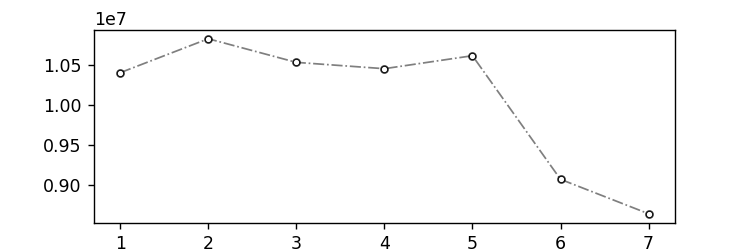

In [23]:
# ver días del modelo
# f = m.predict_f_samples(Xt, num_samples)
sample1 = f[0,:,:] * s + ybar
x = {'day_of_week': [], 'births':[]}
ds = 3
mes = 1
y = 1969
for i in range(7305):
    x['day_of_week'].append(ds)
    x['births'].append(sample1[i])
    ds += 1
    if ds == 8:
        ds = 1
df = pd.DataFrame(x)

x = []
y = []


for i in range(2, 8):
    x.append(i - 1)
    y.append(np.sum(df[df.day_of_week == i].births))
x.append(7)
y.append(np.sum(df[df.day_of_week == 1].births))

fig, ax = plt.subplots(1, figsize=(6, 2))
ax.plot(x, y, 'k-.', alpha=0.5, lw=1)
ax.plot(x, y, 'ko', markersize=4, alpha=0.8)
ax.plot(x, y, 'wo', markersize=2, alpha=1)

<IPython.core.display.Javascript object>


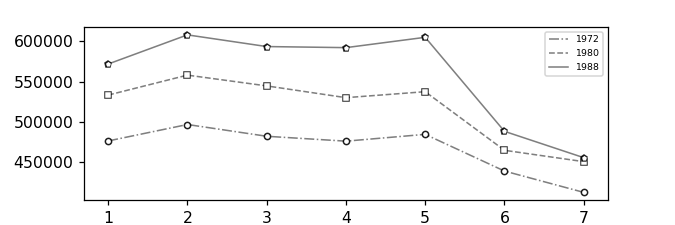

In [568]:
# ver días

x = []
y1 = []
y2 = []
y3 = []

A1 = data[data.year == 1972]
A2 = data[data.year == 1980]
A3 = data[data.year == 1988]

for i in range(1, 8):
    x.append(i)
    
    y1.append(np.sum(A1[A1.day_of_week == i].births))
    y2.append(np.sum(A2[A2.day_of_week == i].births))
    y3.append(np.sum(A3[A3.day_of_week == i].births))
    
fig, ax = plt.subplots(1, figsize=(6, 2))
ax.plot(x, y1, 'k-.', alpha=0.5, lw=1, label='1972')
ax.plot(x, y1, 'ko', markersize=4, alpha=0.8)
ax.plot(x, y1, 'wo', markersize=2, alpha=1)

ax.plot(x, y2, 'k--', alpha=0.5, lw=1, label='1980')
ax.plot(x, y2, 'ks', markersize=4, alpha=0.8)
ax.plot(x, y2, 'ws', markersize=2, alpha=1)

ax.plot(x, y3, 'k-', alpha=0.5, lw=1, label='1988')
ax.plot(x, y3, 'kp', markersize=4, alpha=0.8)
ax.plot(x, y3, 'wp', markersize=2, alpha=1)


# ax.axhline(y=np.mean(y), color='k', lw=1)
ax.legend(loc='upper right', fontsize=6)